In [1]:
import pandas as pd
from src.system import System
from src.sampler import MCMCSampler
from src.model import *
from src.priors import *
from src.results import *
import corner.corner as corner
import matplotlib.pyplot as plt

from WDPhotTools.fitter import WDfitter

In [2]:
df1_data = {'App Mag': [14.23, 14.10], 
            'Errors': [0.36, 0.39], 
            'Filter': ['K', 'H']}
df1 = pd.DataFrame(df1_data)
s = System(df1, 41.4741, 0.0211)

In [3]:
res = Results(s)
res.load_results("trial3-inf.hdf5")
flatchain = np.copy(res.post)
flatchain



array([[5.23936839e-01, 4.95704141e+08, 4.14684302e+01],
       [6.62857469e-01, 1.31396471e+09, 4.14379135e+01],
       [5.93529388e-01, 8.46040836e+08, 4.14197172e+01],
       ...,
       [2.42135005e-01, 1.90595091e+09, 4.15124459e+01],
       [4.69558889e-01, 1.38132237e+09, 4.15034260e+01],
       [7.52854906e-01, 4.46729577e+08, 4.14629821e+01]])

In [4]:
ages = flatchain[:,1]
mass = flatchain[:,0]
teff = np.empty_like(ages)
mdf = maketable("WD", filters=["Teff"])
mdf

,Teff,Age,Mass
0,1500.0,1.418000e+10,0.2
1,1750.0,1.166000e+10,0.2
2,2000.0,9.847000e+09,0.2
3,2250.0,8.347000e+09,0.2
4,2500.0,6.953000e+09,0.2
...,...,...,...
56,110000.0,1.061000e+05,1.3
57,120000.0,0.000000e+00,1.3
58,130000.0,0.000000e+00,1.3
59,140000.0,0.000000e+00,1.3


In [7]:

for i in range(len(ages[9000000:])):
    # Makes the bounds and ensures floats have one decimal (avoiding floating point errors)
    mbounds = (np.around(np.floor(10*mass[i])/10, decimals=1), np.around(np.floor(10*mass[i])/10 + 0.1, decimals=1))

    ts = np.zeros(2)

    # Outer loop runs twice only
    for m in range(len(mbounds)):
        # Make sub dataframe for specific mass
        df = mdf.loc[mdf["Mass"] == mbounds[m]]
        try:
            f = interp1d(df["Age"], df["Teff"])
            ts[m] = f(ages[i])
        except ValueError:
                print(r"Interpolation error: {} M$\odot$, {} yrs".format(mass[i], ages[i]))
    fract = (mass[i] - mbounds[0])/(mbounds[1]-mbounds[0])
    plus = fract * (ts[1] - ts[0])
    t = ts[0] + plus
    teff[i] = t


Interpolation error: 1.2160078302992268 M$\odot$, 7165258981.748324 yrs
Interpolation error: 1.2151933722317128 M$\odot$, 5848952929.123973 yrs
Interpolation error: 0.8424052708628965 M$\odot$, 14370965887.632832 yrs
Interpolation error: 0.8424052708628965 M$\odot$, 14370965887.632832 yrs
Interpolation error: 0.8424052708628965 M$\odot$, 14370965887.632832 yrs
Interpolation error: 0.8424052708628965 M$\odot$, 14370965887.632832 yrs
Interpolation error: 1.1137641192165628 M$\odot$, 8364661406.374084 yrs
Interpolation error: 1.0200504589972175 M$\odot$, 10629661236.189304 yrs
Interpolation error: 1.0200504589972175 M$\odot$, 10629661236.189304 yrs
Interpolation error: 1.0200504589972175 M$\odot$, 10629661236.189304 yrs
Interpolation error: 1.027891913426893 M$\odot$, 11253654210.868784 yrs
Interpolation error: 1.027891913426893 M$\odot$, 11253654210.868784 yrs
Interpolation error: 1.0435114683811961 M$\odot$, 12160679662.27 yrs
Interpolation error: 1.115771167161488 M$\odot$, 8558145272.

KeyboardInterrupt: 

: 

In [16]:
teff

array([10288.26950705,  8015.73513971,  8897.73017759, ...,
           0.        ,     0.        ,     0.        ])

In [ ]:
total_samples, n_params = flatchain.shape
n_steps = np.int(total_samples/200) 
# Reshape it to (nwalkers, nsteps, nparams)
chn = flatchain.reshape((200, n_steps, n_params))

C:\Users\user\AppData\Local\Temp\ipykernel_21104\1970496501.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_steps = np.int(total_samples/200)


In [19]:
chn.shape

(200, 50000, 3)

In [ ]:
flatchain[:,1] *= 1e-9
labels = ['Mass [M$_{{\\odot}}$]', 'Age [Gyr]', 'Parallax [$\\frac{mas}{yr}$]']
flatchain.shape

In [4]:
ftr = WDfitter()
ftr.fit(atmosphere=["H"],
        filters=["K_mko", "H_mko"],
        mags=[12.31651922, 12.19323903],
        mag_errors=[0.31652, 0.35052],
        distance=24.11,
        distance_err=0.012,
        extinction_convolved=False,
        Rv=0.0,
        independent=["Teff", "mass"],
        initial_guess=[5039.69, 0.895],
        method="emcee",
        nwalkers=200,
        nsteps=10000,
        nburns=100,
        progress=True,
        kwargs_for_CT={"tol": 1e-12}
        )


c:\Users\user\anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=3,3 nx,ny=24,12 m=148 fp=0.000188 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\user\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 17/10000 [00:00<07:57, 20.93it/s]c:\Users\user\anaconda3\lib\site-packages\WDPhotTools\atmosphere_model_reader.py:492: RuntimeWarning: invalid value encountered in log10
  x_0 = np.log10(x_0)
100%|██████████| 10000/10000 [07:31<00:00, 22.16it/s]


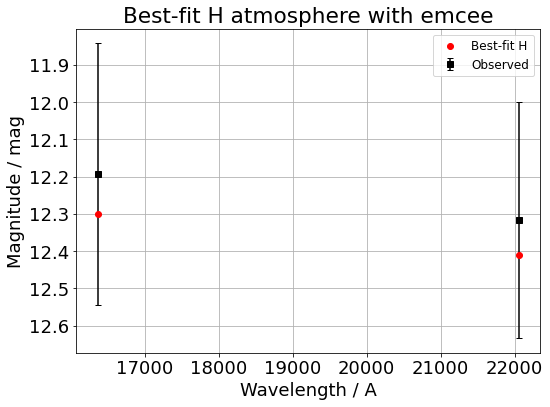

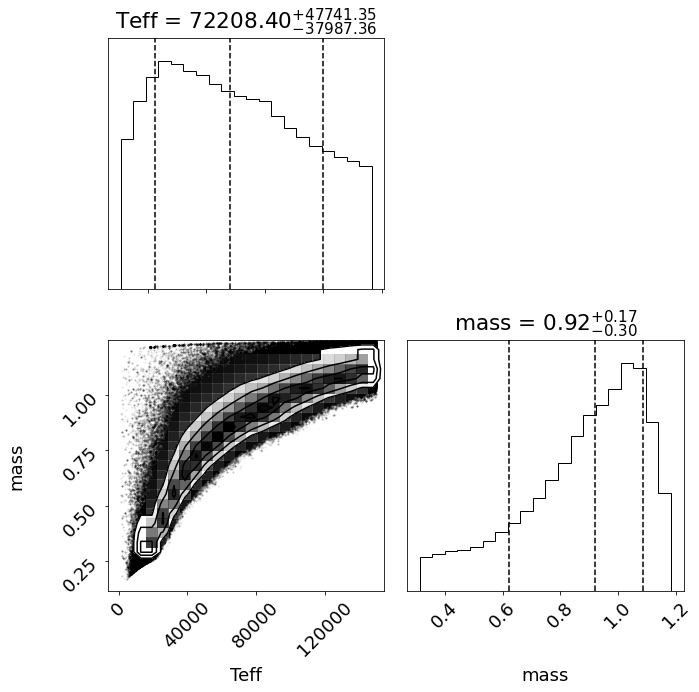

[<Figure size 720x720 with 4 Axes>]

In [5]:
ftr.best_fit_params
ftr.show_best_fit(display=False)
ftr.show_corner_plot(
    figsize=(10, 10),
    display=True,
    kwarg={
        "quantiles": [0.158655, 0.5, 0.841345],
        "show_titles": True,
    },
)

In [36]:
ftr.samples["H"].shape


(1980000, 2)

In [44]:
chain_coo = flatchain[10000000-1980000:]
chain_wdp = ftr.samples["H"][:,1]

In [45]:
chain_wdp = np.column_stack((chain_wdp, np.zeros((1980000,2))))

ValueError: It looks like the parameter(s) in column(s) 1, 2 have no dynamic range. Please provide a `range` argument.

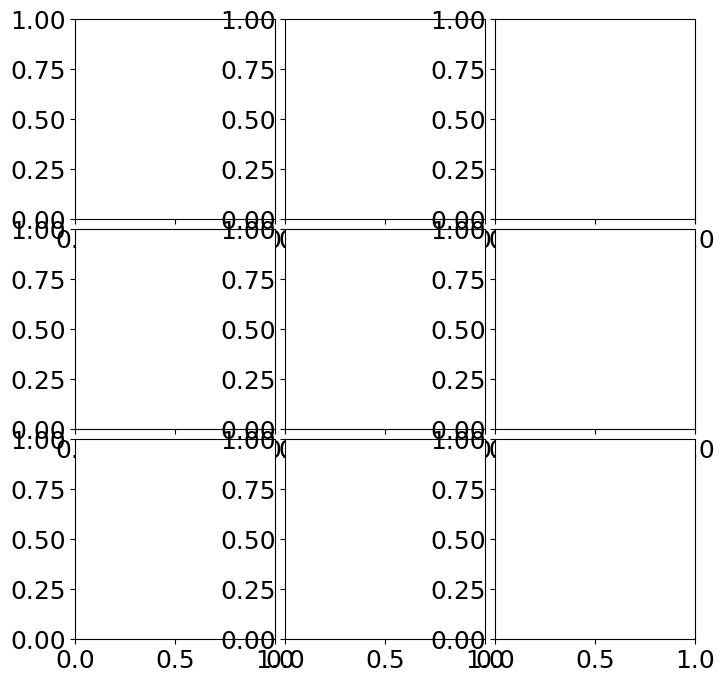

In [46]:
f1 = corner(chain_wdp, quantiles=[0.16,0.5,0.84], show_titles=True)
figure = corner(chain_coo, labels=labels, quantiles=[0.16,0.5,0.84], show_titles=True, fig=f1)